# `Rosie's` Engine Performance Analysis

> Date: 24/05/2025

> Author: Elias Aoubala

In [55]:
from turborocket.transient.start_up import MainEngine
from turborocket.fluids.fluids import IncompressibleFluid
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import handcalcs.render

## 1 - Background

This document contains the authors analysis of the main engine intended to be used for the turbopump cycle for the R2S 2025 competition. 

## 2 - High Level Description

Below, a detailed description of the high level parameters for the engine, along with the sizing criteria has been presented.

**Chamber Parameter**

In [45]:
%%render param sci_not

Pcc = 20e5 # Pa
MR_nom = 2.5
eta_c = 0.95
m_dot_t = 0.55 # kg/s


<IPython.core.display.Latex object>

**Injector Parameters**

Fuel Side:

In [46]:
%%render param sci_not

Pf_inlet = 30e5 # Pa
rho_f_inlet = 786 # kg/s
Cd_f = 0.65

<IPython.core.display.Latex object>

Oxidiser Side:

In [47]:
%%render param sci_not

Po_inlet = 50e5 # Pa
rho_o_inlet = CP.PropsSI("D", "P", Po_inlet, "Q", 0, "NitrousOxide") # kg/s
Cd_o = 0.47

<IPython.core.display.Latex object>

We then define our classes for the gas generator

In [48]:
Nitrous = IncompressibleFluid(
    rho=rho_o_inlet, P=Po_inlet
)
IPA = IncompressibleFluid(rho=rho_f_inlet, P=Pf_inlet)

ME = MainEngine(
    Ox="N2O", Fu="C3H8O,2propanol", Pcc=Pcc, MR=MR_nom
)  # , look_up_file="combustion_date.csv"

ME.comb_object(
    look_up=True, combustion_file="n2o_ipa.yaml", look_up_file="combustion_date.csv"
)

In [49]:
ME.injector_cond(ox_in=Nitrous, fu_in=IPA, cdo=Cd_o, cdf=Cd_f)

ME.size_system(m_dot=m_dot_t, eta_c=eta_c)

{'P_cc': 2000000.0,
 'MR': np.float64(2.4999999999999996),
 'T_o': array([1988.5312729]),
 'Cp': array([1903.61731215]),
 'gamma': array([1.27604013]),
 'R': array([411.80113617]),
 'ox_stiffness': 1.5,
 'fu_stiffness': 0.5,
 'm_dot_t': array([0.55]),
 'm_dot_o': array([0.39285714]),
 'm_dot_f': array([0.15714286])}

In [51]:
geom = ME.get_geometry()

# print(geom)
Acc = geom["Acc"][0]
D_t = 2 * (Acc/np.pi)**(1/2) *1e3

D_ox = 2*(geom["A_ox"]/ (np.pi* 16))**(1/2) *1e3

D_fu = 2*(geom["A_fu"]/ (np.pi* 16))**(1/2) *1e3

print(f"Throat Diameter: {D_t:.2f}")
print(f"Fuel Orifice Diameter: {D_fu:.2f}")
print(f"Ox Orifice Diameter: {D_ox:.2f}")

Throat Diameter: 21.86
Fuel Orifice Diameter: 0.70
Ox Orifice Diameter: 0.98


## 3 - Deep Throttling Study

We will now iterate through a range of inlet pressures to see how the engine would perform accordingly.

We will also set a more reasonable c* efficiency at this point.

In [56]:
ME.set_stochastic_parameters(eta_c=0.85)

In [59]:
P_inlet_array = np.linspace(25, 70, 100)*1e5

P_cc_array = []
MR_array = []
T_o_array = []
cp_array = []
gamma_array = []
ox_stiff_array = []
fu_stiff_array = []
m_dot_t_array = []
m_dot_ox_array = []
m_dot_fu_array = []
error_array = []

for p in P_inlet_array:

    fuel = IncompressibleFluid(rho=rho_f_inlet, P=p)

    
    dic = ME.solve_perturb_ss(fu_in=fuel, ox_in=Nitrous)

    P_cc_array.append(dic["P_cc"])
    MR_array.append(dic["MR"])
    T_o_array.append(dic["T_o"])
    cp_array.append(dic["Cp"])
    gamma_array.append(dic["gamma"])
    ox_stiff_array.append(dic["ox_stiffness"])
    fu_stiff_array.append(dic["fu_stiffness"])
    m_dot_t_array.append(dic["m_dot_t"])
    m_dot_ox_array.append(dic["m_dot_o"])
    m_dot_fu_array.append(dic["m_dot_f"])
    error_array.append(dic["error"])

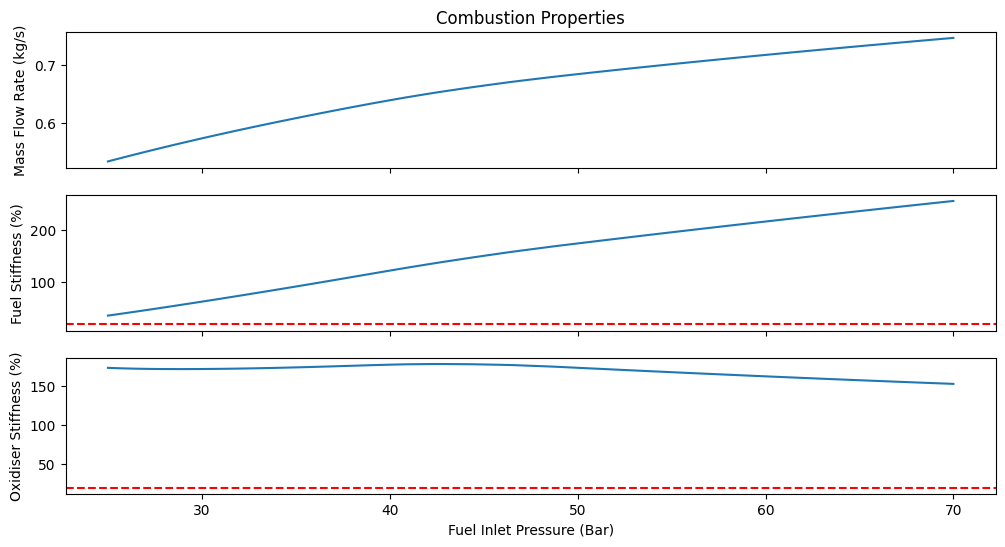

In [63]:
fig, ax = plt.subplots(3,1, sharex=True)

fig.set_size_inches(12, 6)

# First Plot will be the Total Enthalpy Delivered
ax[0].plot(P_inlet_array / 1e5, m_dot_t_array)
ax[0].set_ylabel("Mass Flow Rate (kg/s)")
ax[0].set_title("Combustion Properties")


# Second Plot will be Fuel Stiffness
ax[1].plot(P_inlet_array/1e5, np.array(fu_stiff_array)*100)
ax[1].set_ylabel("Fuel Stiffness (%)")
ax[1].axhline(20, linestyle="--", color="r")


# Thrid Plot will be Oxidiser Stiffness
ax[2].plot(P_inlet_array/1e5, np.array(ox_stiff_array)*100)
ax[2].set_ylabel("Oxidiser Stiffness (%)")
ax[2].set_xlabel("Fuel Inlet Pressure (Bar)")
ax[2].axhline(20, linestyle="--", color="r")

Text(0.5, 0, 'Fuel Inlet Pressure (Bar)')

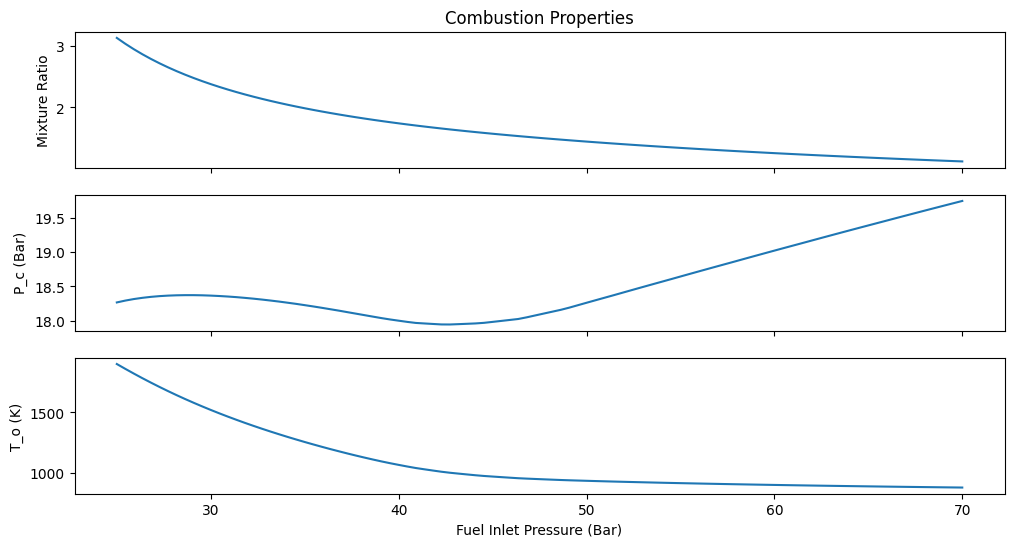

In [62]:
fig, ax = plt.subplots(3, 1, sharex=True)

fig.set_size_inches(12, 6)

# First Plot will be Mixture Ratio
ax[0].plot(P_inlet_array / 1e5, MR_array)
ax[0].set_ylabel("Mixture Ratio")
ax[0].set_title("Combustion Properties")


# Second Plot will be Chamber Pressure
ax[1].plot(P_inlet_array / 1e5, np.array(P_cc_array) / 1e5)
ax[1].set_ylabel("P_c (Bar)")


# Thrid Plot will be Stagnation Temperature
ax[2].plot(P_inlet_array / 1e5, T_o_array)
ax[2].set_ylabel("T_o (K)")
ax[2].set_xlabel("Fuel Inlet Pressure (Bar)")